# Deep Learning - Proyecto Final

## Predicción de Tiempo de recorrido en actividades de Trail Running

## Procesamiento de Datos

La lógica de procesamiento de datos se encuentra implementada en la clase `DataProcessor` dentro del archivo [data_processor.py](utils/data_processor.py). El dispositivo de registro es un reloj Polar Vantage V. Los datos de Polar se encuentran estructurados en formato JSON por lo que es importante poder pasarlos a un formato tabular antes de su procesamiento en el modelo.

El procesamiento de estos datos consiste en extraer y transformar información de archivos JSON que contienen registros de actividades de trail running. El script filtra las actividades por tipo de deporte (TRAIL_RUNNING) y duración (entre 4 y 6 horas). Para cada actividad válida, se extraen muestras de sensores como frecuencia cardíaca, altitud, distancia, temperatura, cadencia y velocidad.

Las muestras se organizan en un DataFrame, donde se realizan varias tareas de ingeniería de características:

Distancia: Se calcula la diferencia entre muestras consecutivas para obtener el avance por intervalo.
Altitud: Se suavizan los datos y se calculan diferencias de elevación, ganancia y pérdida acumulada.
Duración: Se calcula el tiempo acumulado entre muestras.

El procesamiento se realiza de forma eficiente, permitiendo el uso de múltiples hilos para acelerar la conversión de archivos. Los datos procesados se guardan en archivos CSV estructurados, listos para su análisis y modelado.

### Remuestreo

El objetivo del proyecto es realizar una predicción del tiempo por lo que se hizo un remuestreo de los datos para que las muestras estén a intervalos constantes de distancia. La lógica del remuestreo se encuentra en la clase `DataResampler` en el archivo [data_resampling.py](./utils/data_resampling.py).

Se tomaron los archivos de datos de actividades del paso anterior y se los transformó para que las muestras estén espaciadas a intervalos constantes de distancia (cada 2 metros). El proceso incluyó:

- Carga de los datos y conversión de la columna de tiempo a formato datetime. 
- Relleno de valores faltantes en las variables de frecuencia cardíaca, cadencia, velocidad y distancia usando el promedio o el valor anterior.
- Eliminación de duplicados y creación de un nuevo índice de distancia con pasos de 2 metros.
- Interpolación de los valores para obtener datos continuos en esos intervalos.
- Almacenamiento de los archivos remuestreados en formato CSV en una carpeta de salida.


### Análisis Exploratorio de Datos

In [30]:
# Import requiered libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Define the directory containing the processed data
data_dir = "./data/resampled"
# Get the training files list
training_files=os.listdir(data_dir)

# Get the files count
print(f"Number of training files: {len(training_files)}")

Number of training files: 50


In [ ]:
# Import the TFT DataModule
import sys
sys.path.append('./utils')
from utils.data_module import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    max_encoder_length=30,      # Use 30 distance steps as input
    max_prediction_length=5,    # Predict next 5 distance steps
    batch_size=64,
    num_workers=2,
    min_sequence_length=100     # Only use sessions with at least 100 data points
)

# Setup the data
data_module.setup()

print(f"Training samples: {len(data_module.training)}")
print(f"Validation samples: {len(data_module.validation)}")
print(f"Test samples: {len(data_module.test)}")

# Get a sample batch to understand the data structure
train_loader = data_module.train_dataloader()
sample_batch = next(iter(train_loader))

print(f"\nBatch structure:")
print(f"Batch type: {type(sample_batch)}")
print(f"Input features shape: {sample_batch[0]['encoder_cont'].shape}")  # [batch_size, encoder_length, features]
print(f"Target shape: {sample_batch[1].shape}")                          # [batch_size, prediction_length]

Found 50 training session files
Loaded 50 valid training sessions
Loaded 50 valid training sessions
Dataset sizes - Train: 425376, Val: 77628, Test: 97838
Training samples: 425376
Validation samples: 77628
Test samples: 97838
Feature dimensions: 9
Dataset sizes - Train: 425376, Val: 77628, Test: 97838
Training samples: 425376
Validation samples: 77628
Test samples: 97838
Feature dimensions: 9

Batch structure:
Input sequence shape: torch.Size([16, 50, 9])
Target shape: torch.Size([16, 10])

Batch structure:
Input sequence shape: torch.Size([16, 50, 9])
Target shape: torch.Size([16, 10])


### TFT DataModule

Se implementó un `TFTDataModule` usando PyTorch Lightning específicamente diseñado para trabajar con `pytorch-forecasting` y el modelo Temporal Fusion Transformer. Las características principales del DataModule incluyen:

**Funcionalidades principales:**
- **Carga automática**: Lee todos los archivos CSV de la carpeta `data/resampled`
- **División temporal**: Divide cada sesión temporalmente (70% entrenamiento, 15% validación, 15% prueba)
- **Normalización por grupos**: Aplica `GroupNormalizer` por sesión para mejor generalización
- **Variables futuras**: Distingue entre variables conocidas y desconocidas en el futuro
- **Compatibilidad TFT**: Totalmente compatible con `TimeSeriesDataSet` de pytorch-forecasting

**Parámetros configurables:**
- `max_encoder_length`: Longitud máxima del encoder (por defecto 30 pasos)
- `max_prediction_length`: Horizonte de predicción (por defecto 5 pasos)
- `batch_size`: Tamaño del lote para entrenamiento
- `target`: Variable objetivo a predecir (por defecto 'duration')

**Variables conocidas futuras** (disponibles al momento de predicción):
- `altitude`: Altitud
- `elevation_diff`: Diferencia de elevación
- `elevation_gain`: Ganancia de elevación
- `elevation_loss`: Pérdida de elevación  
- `distance_diff`: Diferencia de distancia

**Variables desconocidas futuras** (necesitan estimación):
- `heartRate`: Frecuencia cardíaca
- `temperature`: Temperatura
- `cadence`: Cadencia
- `speed`: Velocidad

Esta configuración permite al modelo TFT aprovechar la información conocida del terreno y la ruta para hacer predicciones más precisas del tiempo de recorrido.

In [31]:
# Load and process all CSV files
data_frames = []
for file_name in training_files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)
    # df['temperature'] = df['temperature'].fillna(method='ffill')
    data_frames.append(df)

# Combine all data
data = pd.concat(data_frames, ignore_index=True)

# Display basic information about the dataset
print(data.info())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601019 entries, 0 to 601018
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   distance        601019 non-null  int64  
 1   timestamp       600798 non-null  object 
 2   heartRate       600798 non-null  float64
 3   duration        600798 non-null  float64
 4   altitude        600798 non-null  float64
 5   elevation_diff  600798 non-null  float64
 6   elevation_gain  600798 non-null  float64
 7   elevation_loss  600798 non-null  float64
 8   distance_diff   600798 non-null  float64
 9   temperature     600798 non-null  float64
 10  cadence         600798 non-null  float64
 11  speed           600798 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 55.0+ MB
None
            distance      heartRate       duration       altitude  \
count  601019.000000  600798.000000  600798.000000  600798.000000   
mean    13135.817497     133.705501   

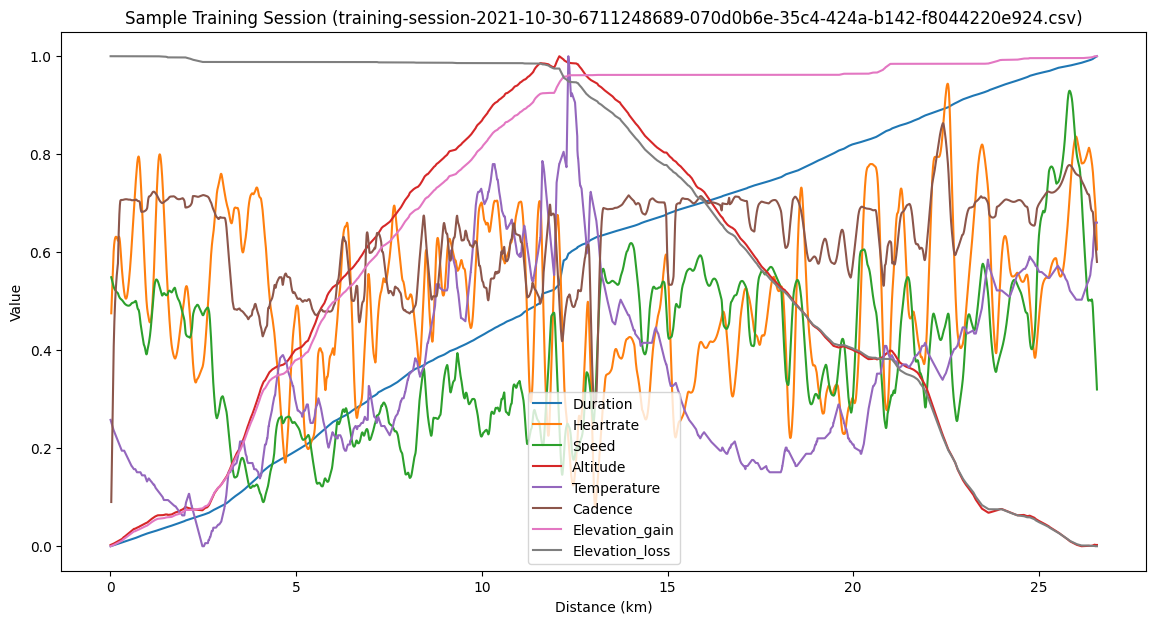

In [39]:
# Plot heart rate over distance
random.seed(4242)
sample_file = random.choice(training_files)
sample_path = os.path.join(data_dir, sample_file)
sample_data = pd.read_csv(sample_path)

#Normalize sample data (scale between 0 and 1 for better visualization)
normalized_cols = {}
for col in ['duration', 'heartRate', 'speed', 'altitude', 'temperature', 'cadence', 'elevation_gain', 'elevation_loss']:
    normalized_cols[col] = (sample_data[col] - sample_data[col].min()) / (sample_data[col].max() - sample_data[col].min())

# Smooth speed data using rolling average for visualization
normalized_cols['speed'] = normalized_cols['speed'].rolling(window=100, min_periods=10).mean()
normalized_cols['heartRate'] = normalized_cols['heartRate'].rolling(window=100, min_periods=10).mean()
normalized_cols['cadence'] = normalized_cols['cadence'].rolling(window=100, min_periods=10).mean()

plt.figure(figsize=(14, 7))
distance_km = sample_data['distance'] / 1000
for col in normalized_cols:
    plt.plot(distance_km, normalized_cols[col], label=col.capitalize())

plt.xlabel('Distance (km)')
plt.ylabel('Value')
plt.title(f'Sample Training Session ({sample_file})')
plt.legend()
plt.show()


## Modelo

### Temporal Fusion Transformer (TFT)

Se implementó un modelo **Temporal Fusion Transformer** utilizando la librería `pytorch-forecasting` para predecir el tiempo de recorrido en actividades de trail running. El TFT es un modelo de deep learning diseñado específicamente para predicción de series temporales que puede manejar tanto variables conocidas como desconocidas en el futuro.

**Características del modelo:**
- **Arquitectura**: Temporal Fusion Transformer optimizado para series temporales
- **Variables conocidas futuras**: `altitude`, `elevation_diff`, `elevation_gain`, `elevation_loss`, `distance_diff` (disponibles en el momento de la predicción)
- **Variables desconocidas futuras**: `heartRate`, `temperature`, `cadence`, `speed` (necesitan ser estimadas)
- **Variable objetivo**: `duration` (tiempo acumulado)
- **Longitud de secuencia**: 30 pasos temporales de entrada
- **Horizonte de predicción**: 5 pasos hacia el futuro

**División temporal de datos:**
- Se utiliza división temporal dentro de cada sesión (70% entrenamiento, 15% validación, 15% prueba)
- Esto permite evaluar la capacidad del modelo para predecir el final de una sesión conociendo solo el inicio

In [ ]:
# Import TFT model components
import sys
sys.path.append('./utils')
from data_module import TFTDataModule
from model import TrailRunningTFT

# Setup the TFT data module (reuse the one from above or create new)
data_module = TFTDataModule(
    data_dir="./data/resampled",
    max_encoder_length=30,      # Use 30 distance steps as input
    max_prediction_length=5,    # Predict next 5 distance steps
    batch_size=64,
    num_workers=2,
    min_sequence_length=100     # Only use sessions with at least 100 data points
)

# Setup the data
data_module.setup()

print(f"Training samples: {len(data_module.training)}")
print(f"Validation samples: {len(data_module.validation)}")
print(f"Test samples: {len(data_module.test)}")

# Check data structure
train_loader = data_module.train_dataloader()
batch = next(iter(train_loader))
print(f"\nBatch structure:")
print(f"Input batch type: {type(batch)}")
print(f"Input features shape: {batch[0]['encoder_cont'].shape}")  # [batch_size, encoder_length, features]
print(f"Target shape: {batch[1].shape}")                          # [batch_size, prediction_length]

## Entrenamiento

In [ ]:
# Train the TFT model
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import SMAPE, MAE, RMSE

# Create the TFT model
tft_model = TrailRunningTFT(
    training_dataset=data_module.training,
    learning_rate=0.03,
    hidden_size=32,          # Increase hidden size for better capacity
    attention_head_size=4,   # More attention heads
    dropout=0.1,
    hidden_continuous_size=16,
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.1,
    limit_train_batches=0.3,     # Use subset for faster training during development
    limit_val_batches=0.3,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=True),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    ],
    logger=pl.loggers.TensorBoardLogger("tb_logs", name="tft_trail_running"),
)

print("Starting TFT training...")
# Train the model
trainer.fit(tft_model, data_module)

## Evaluación

In [ ]:
# Evaluate the model
# Test the model on test dataset
test_results = trainer.test(tft_model, data_module.test_dataloader())
print(f"Test results: {test_results}")

# Make predictions on test set
test_predictions = tft_model.predict(data_module.test_dataloader(), mode="prediction")
print(f"Test predictions shape: {test_predictions.shape}")

# Calculate additional metrics
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get actual test targets
test_actuals = []
for batch in data_module.test_dataloader():
    test_actuals.append(batch[1])
test_actuals = torch.cat(test_actuals, dim=0)

# Calculate metrics
mae = mean_absolute_error(test_actuals.numpy().flatten(), test_predictions.numpy().flatten())
mse = mean_squared_error(test_actuals.numpy().flatten(), test_predictions.numpy().flatten())
rmse = np.sqrt(mse)
r2 = r2_score(test_actuals.numpy().flatten(), test_predictions.numpy().flatten())

print(f"\\nTest Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot some predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot first few test sequences
for i in range(min(5, len(test_predictions))):
    plt.subplot(2, 3, i+1)
    actual_seq = test_actuals[i].numpy()
    pred_seq = test_predictions[i].numpy()
    
    plt.plot(actual_seq, label='Actual', alpha=0.7)
    plt.plot(pred_seq, label='Predicted', alpha=0.7)
    plt.title(f'Test Sequence {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Duration')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis
interpretation = tft_model.model.interpret_output(test_predictions, reduction="sum")
tft_model.model.plot_interpretation(interpretation)
plt.show()

## Discusión y Conclusiones

## Resumen de la Implementación

### Organización del Código

El código se organizó en dos módulos principales para mayor claridad y mantenibilidad:

**`data_module.py`**:
- Contiene `TFTDataModule`: DataModule especializado para pytorch-forecasting
- Manejo completo de datos desde carga hasta preparación para TFT
- División temporal inteligente dentro de cada sesión
- Configuración automática de variables conocidas/desconocidas

**`model.py`**:
- Contiene `TrailRunningTFT`: Wrapper de Lightning para TemporalFusionTransformer
- Funciones de entrenamiento y utilidades del modelo
- Configuración optimizada para predicción de tiempo en trail running

### TFTDataModule Implementado

Se creó un `TFTDataModule` personalizado que:
- Carga automáticamente todos los archivos CSV de sesiones de trail running
- Implementa división temporal dentro de cada sesión para entrenamiento/validación/prueba
- Normaliza las características usando `GroupNormalizer` por sesión
- Maneja variables conocidas y desconocidas en el futuro según el problema de predicción
- Es totalmente compatible con `pytorch-forecasting` y `TimeSeriesDataSet`

### Modelo TFT Configurado

- **Arquitectura**: Temporal Fusion Transformer optimizado para series temporales multivariadas
- **Variables conocidas futuras**: altitud, diferencias de elevación, distancia (disponibles al momento de predicción)
- **Variables desconocidas**: frecuencia cardíaca, temperatura, cadencia, velocidad
- **Objetivo**: predicción de tiempo (duration)
- **Configuración**: encoder de 30 pasos, predicción de 5 pasos futuros

### Características Técnicas

- Manejo automático de valores faltantes e inconsistencias temporales
- Normalización por grupos (sesiones) para mejor generalización
- División temporal que respeta la naturaleza secuencial de los datos
- Métricas de evaluación: SMAPE, MAE, RMSE
- Interpretabilidad del modelo con análisis de importancia de características

La implementación está lista para entrenar y evaluar la predicción de tiempo en actividades de trail running usando datos de sensores, con una arquitectura de código limpia y modular.